In [132]:
### PLAN ###

# For only cornel soil data
# cluster the data at the level of LCMS runs
# and then compute the average spectrum for each cluster
# and then compute the shannon diversity for each cluster

# The environment and depth are the major factors

# for each cluster identify the major structural features that are identified

# demonstrates that you can get what you got from the classical analysis and more


# grab the russel ranch treatments and calculatre diversity


In [133]:
from pyteomics import mgf
import pandas as pd
import numpy as np
import glob as glob
import os
import matplotlib.pyplot as plt
import networkx as nx
import pingouin as pg
import seaborn as sns
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft

In [134]:
# G = nx.read_graphml('../data/structural_clusters_network.graphml')
G = nx.read_graphml('../data/network.graphml')
df = dict(G.nodes(data=True))
df = pd.DataFrame(df).T
df.index.name = 'node_id'
df.reset_index(inplace=True,drop=False)
df.head()
df.columns

Index(['node_id', 'dbe_ai_mod', 'round3_precursor_mz', 'nosc',
       'smiles_identity', 'inchi_key_identity', 'max_matches_identity', 'c',
       'precursor_mz_analog', 'ai', 'n_to_c', 'p_to_c', 'predicted_formula',
       'p', 'name_analog', 'name_identity', 'precursor_mz', 'o_to_c',
       'original_index', 'h', 'n_to_p', 'dbe', 'sum_frag_intensity', 'n',
       'coisolated_precursor_count', 'rt', 'h_to_c', 'dbe_ai',
       'max_frag_intensity', 'max_score_identity',
       'original_p2d2_index_identity', 'estimated_fdr', 'count',
       'formula_identity', 'assumed_adduct', 'max_score_analog',
       'precursor_mz_identity', 'smiles_analog', 'best_match_method_analog',
       'formula_analog', 'original_p2d2_index_analog', 'inchi_key_analog', 's',
       'ai_mod', 'o', 'best_match_method_identity', 'isolated_precursor_mz',
       'mcs_structural_cluster_number', 'mcs_structural_pattern',
       'mcs_similarity'],
      dtype='object')

In [135]:
# file = '/pscratch/sd/b/bpb/data_for_wave-database'
file = '/global/cfs/cdirs/metatlas/raw_data/egsb/20220718_LZH_RL_SOM_persist_set1_QE119_C18-EP_USDAY59441'
files = glob.glob(os.path.join(file,'*NEG*.h5'))
files = [f for f in files if not 'exctrl' in f.lower()]
files = [f for f in files if not 'qc' in f.lower()]
# files_to_use = ['/pscratch/sd/ /b/bpb/data_for_wave-database/20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_QE-HF_C18_USDAY63680_NEG_MSMS_35_SC-Control_5_Rg80to1200-CE102040-soil-Oxisol-S1_Run212.h5',
                # '/pscratch/sd/b/bpb/data_for_wave-database/20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_QE-HF_C18_USDAY63680_NEG_MSMS_34_SC-Control_4_Rg80to1200-CE102040-soil-Oxisol-S1_Run167.h5',
# '/pscratch/sd/b/bpb/data_for_wave-database/20220707_JGI_SB_503799_Permafrost_pilot_QE-HF_C18_USDAY63663_NEG_MSMS_10_55M-Subsection-MeOH_1_Rg80to1200-CE102040-soil-S1_Run26.h5']

files = pd.DataFrame(files,columns=['filename'])
# files = files[files['filename'].isin(files_to_use)]
files['experiment'] = files['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[4:6]))
files['sampletype'] = files['filename'].apply(lambda x: x.split('/')[-1].split('_')[12])
# # files['sampletype'] = files['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[12:15]))
# print(files['experiment'].unique())
# # experiments = ['Permafrost_pilot', 'SoilWetDry_final',
#        # 'GEODES_All3', 'FRCgw2_20230830','OMTSoil50g_Pilot']
# # files = files[files['experiment'].isin(experiments)]
files['sampletype'].unique()
# files

array(['deciduousforests-a', 'deciduousforests-litter', 'tundra-litter',
       'desertshrubs-litter', 'coniferousforests-c', 'tundra-a',
       'coniferousforests-litter', 'tundra-c', 'grasses-b',
       'coniferousforests-a', 'mixedforests-b', 'grasses-litter',
       'mixedforests-c', 'grasses-c', 'deciduousforests-c',
       'desertshrubs-b', 'desertshrubs-a', 'grasses-a', 'desertshrubs-c',
       'mixedforests-a', 'mixedforests-litter', 'coniferousforests-b',
       'deciduousforests-b'], dtype=object)

In [136]:

ppm_tolerance = 10
mz_tol = 0.002
rt_min = 1
rt_max = 7

atlas = df[['node_id','precursor_mz']].copy()
atlas.rename(columns={'precursor_mz':'mz','node_id':'label'},inplace=True)
atlas['rt_min'] = rt_min
atlas['rt_max'] = rt_max
atlas['mz_tolerance'] = mz_tol
atlas['rt_tolerance'] = 100
atlas['ppm_tolerance'] = ppm_tolerance
atlas['extra_time'] = 0
atlas['rt_peak'] = (rt_min+rt_max)/2  
atlas['group_index'] = ft.group_consecutive(atlas['mz'].values[:],
                                    stepsize=ppm_tolerance,
                                    do_ppm=True)

out = []
counter = 0
for f in files['filename']:
    try:
        d = ft.get_atlas_data_from_file(f,atlas,desired_key='ms1_neg')
    except:
        print('Can not read',f)
        continue
    d = d[d['in_feature']==True].groupby('label').apply(ft.calculate_ms1_summary).reset_index()
    d['filename'] = f
    out.append(d)
    counter += 1
    print(counter)
out = pd.concat(out)
out.rename(columns={'label':'node_id'},inplace=True)

out

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


,node_id,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,filename
0,0.0,688.0,6.424483e+08,3.402952e+07,187.097545,3.455222,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...
1,1.0,688.0,7.626224e+07,4.634687e+05,347.186433,6.432751,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...
2,10.0,684.0,5.823216e+07,3.182084e+06,188.100869,3.455222,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...
3,100.0,375.0,7.242548e+06,7.115102e+04,275.056226,3.698181,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...
4,1000.0,672.0,4.765933e+07,5.580991e+05,295.118561,2.637869,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...
...,...,...,...,...,...,...,...
3077,994.0,53.0,3.960202e+05,3.651802e+04,325.055856,5.001277,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...
3078,995.0,13.0,1.524987e+05,2.454951e+04,261.043202,2.935713,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...
3079,996.0,660.0,1.294184e+07,7.370520e+04,271.081948,3.221261,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...
3080,997.0,1.0,1.087290e+04,1.087290e+04,583.370567,6.984910,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...


In [137]:
out['experiment'] = out['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[4:6]))
out['sampletype'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[12])
out['depth'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[12].split('-')[-1])
out['environment'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[12].split('-')[0])
out
# out['sampletype1'] = out['filename'].apply(lambda x: '-'.join(x.split('/')[-1].split('_')[12].split('-')[1:]))
# # out['sampletype2'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[14].split('-')[3])
# g = out.groupby('filename')['peak_area'].median()
# g.sort_values(ascending=False,inplace=True)
# g.head(20).to_csv('ones_that_are_big.csv')

,node_id,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,filename,experiment,sampletype,depth,environment
0,0.0,688.0,6.424483e+08,3.402952e+07,187.097545,3.455222,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...,persist_set1,deciduousforests-a,a,deciduousforests
1,1.0,688.0,7.626224e+07,4.634687e+05,347.186433,6.432751,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...,persist_set1,deciduousforests-a,a,deciduousforests
2,10.0,684.0,5.823216e+07,3.182084e+06,188.100869,3.455222,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...,persist_set1,deciduousforests-a,a,deciduousforests
3,100.0,375.0,7.242548e+06,7.115102e+04,275.056226,3.698181,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...,persist_set1,deciduousforests-a,a,deciduousforests
4,1000.0,672.0,4.765933e+07,5.580991e+05,295.118561,2.637869,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...,persist_set1,deciduousforests-a,a,deciduousforests
...,...,...,...,...,...,...,...,...,...,...,...
3077,994.0,53.0,3.960202e+05,3.651802e+04,325.055856,5.001277,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...,persist_set1,grasses-a,a,grasses
3078,995.0,13.0,1.524987e+05,2.454951e+04,261.043202,2.935713,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...,persist_set1,grasses-a,a,grasses
3079,996.0,660.0,1.294184e+07,7.370520e+04,271.081948,3.221261,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...,persist_set1,grasses-a,a,grasses
3080,997.0,1.0,1.087290e+04,1.087290e+04,583.370567,6.984910,/global/cfs/cdirs/metatlas/raw_data/egsb/20220...,persist_set1,grasses-a,a,grasses


In [139]:

d = out.pivot_table(columns='node_id',index=['depth','environment'],values='peak_area',aggfunc='mean',fill_value=300)
# d.reset_index(inplace=True,drop=False)
d

node_id                            0.0           1.0          10.0  \
depth  environment                                                   
a      coniferousforests  1.332300e+09  3.777720e+08  1.249429e+08   
       deciduousforests   4.748988e+08  2.314876e+08  4.329364e+07   
       desertshrubs       9.867987e+08  1.675680e+08  9.196139e+07   
       grasses            5.033951e+08  7.686419e+07  4.536797e+07   
       mixedforests       6.809527e+08  2.289229e+08  6.256124e+07   
       tundra             8.592078e+08  4.709555e+07  7.914821e+07   
b      coniferousforests  3.198023e+08  7.857628e+07  2.817924e+07   
       deciduousforests   8.073816e+08  8.608816e+07  7.562394e+07   
       desertshrubs       4.608691e+08  4.438360e+07  4.192717e+07   
       grasses            9.915366e+07  8.514270e+06  8.533985e+06   
       mixedforests       1.675008e+09  1.498013e+08  1.568633e+08   
c      coniferousforests  7.303845e+08  9.891900e+07  6.701288e+07   
       deciduousforests   5.348595e+08  7.305216e+07  4.838754e+07   
       desertshrubs       2.166480e+08  2.156873e+07  1.937926e+07   
       grasses            9.138582e+08  1.111765e+08  8.570223e+07   
       mixedforests       7.880967e+08  4.919056e+07  7.331415e+07   
       tundra             1.525226e+09  6.400379e+07  1.436207e+08   
litter coniferousforests  2.174264e+10  6.763252e+09  2.080262e+09   
       deciduousforests   3.158967e+10  2.724818e+09  3.056945e+09   
       desertshrubs       6.220587e+09  3.164302e+07  5.789493e+08   
       grasses            8.919925e+09  5.226951e+07  8.459812e+08   
       mixedforests       2.751343e+10  3.692231e+08  2.669849e+09   
       tundra             8.590907e+09  1.453849e+08  8.184733e+08   

node_id                          100.0        1000.0        1001.0  \
depth  environment                                                   
a      coniferousforests  3.316716e+07  1.825788e+08  1.323985e+07   
       deciduousforests   1.049363e+07  4.705828e+07  5.671762e+06   
       desertshrubs       1.120717e+07  1.078681e+08  6.528216e+06   
       grasses            1.647011e+07  2.426159e+07  4.760191e+06   
       mixedforests       1.287717e+07  6.505771e+07  8.597116e+06   
       tundra             1.287489e+07  1.452163e+08  1.185965e+07   
b      coniferousforests  4.916636e+06  1.391487e+07  2.325109e+06   
       deciduousforests   7.400004e+06  5.097002e+07  1.087466e+07   
       desertshrubs       3.205801e+06  1.904041e+07  4.780379e+06   
       grasses            6.307145e+05  1.022807e+07  3.497691e+06   
       mixedforests       2.067424e+07  1.891752e+08  1.605772e+07   
c      coniferousforests  1.152010e+07  1.448624e+08  9.199788e+06   
       deciduousforests   4.199176e+06  2.212190e+07  6.784486e+06   
       desertshrubs       1.774742e+06  2.796461e+07  3.698943e+06   
       grasses            8.866904e+06  1.708297e+08  6.365410e+06   
       mixedforests       1.195771e+07  7.006159e+07  1.262740e+07   
       tundra             1.291681e+07  9.441921e+07  1.169434e+07   
litter coniferousforests  3.032023e+08  9.356086e+08  7.764089e+07   
       deciduousforests   1.904724e+08  1.214061e+09  9.576148e+07   
       desertshrubs       9.343035e+07  2.012264e+08  3.200930e+07   
       grasses            1.523249e+07  3.490040e+07  1.520107e+07   
       mixedforests       9.750910e+07  3.075881e+08  6.023494e+07   
       tundra             8.478476e+07  2.754591e+08  6.120078e+07   

node_id                         1002.0        1003.0        1006.0  \
depth  environment                                                   
a      coniferousforests  9.660122e+06  8.765970e+07  1.316339e+08   
       deciduousforests   4.458282e+06  2.646752e+07  2.998329e+07   
       desertshrubs       5.417412e+06  3.015490e+07  5.257956e+07   
       grasses            3.570718e+07  2.930931e+07  2.954038e+07   
       mixedforests       5.401092e+06  2.467806e+07  4.715386e+07   
       t

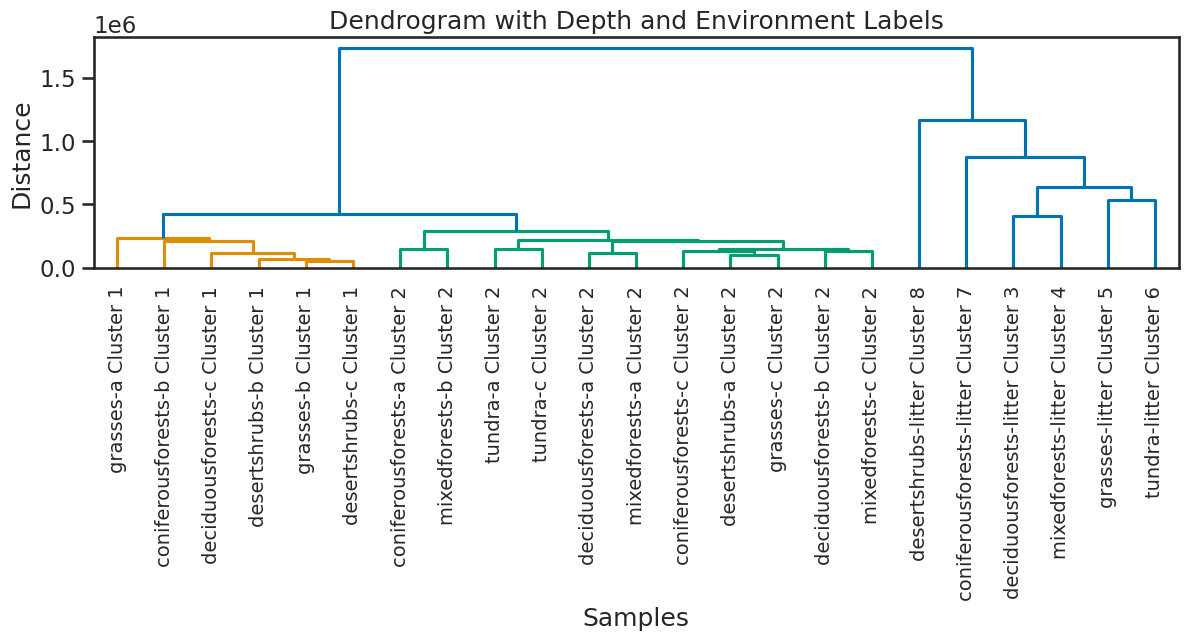

In [185]:
from scipy.cluster.hierarchy import linkage, fcluster
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

# Perform hierarchical clustering
Z = linkage(d.apply(lambda x: x**0.5), method='ward', metric='euclidean')
import matplotlib.pyplot as plt
# Plot the dendrogram
plt.figure(figsize=(14, 3))

clusters = fcluster(Z, 0.3e6, criterion='distance')
d['cluster'] = clusters
cluster_strings = [f"{index[1]}-{index[0]} Cluster {cluster}" for index, cluster in zip(d.index, d['cluster'])]
dendrogram(Z, labels=cluster_strings, leaf_font_size=14,color_threshold=0.3e6,)

# Set plot title and labels
plt.title("Dendrogram with Depth and Environment Labels")
plt.xlabel("Samples")
plt.ylabel("Distance")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [191]:
d = d[d['cluster']<=2]
temp = d.groupby('cluster').apply(lambda x: x.mean(axis=0)).T
temp['fold_change_cluster1-over2'] = np.log2(temp[1]/temp[2])
backup_G = G.copy()
nx.set_node_attributes(backup_G, temp.to_dict('index'))
nx.write_graphml(backup_G,'../data/network_cornell-pnas-clusters.graphml')


In [195]:
def shannon_diversity_index(m,threshold=1e7,q=2):
    # m = m>threshold
    probabilities = m / m.sum()
    shannon_diversity_index = -np.sum(probabilities * np.log2(probabilities))
    return shannon_diversity_index
    # probabilities = m / m.sum()
    # hill_number = np.sum(probabilities**q)**(1/(1-q))
    # return hill_number

temp[[1,2]].apply(shannon_diversity_index,axis=0)


cluster
1    9.359697
2    9.986632
dtype: float64

/tmp/ipykernel_340148/2975907303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p.sort_values('fold_change_cluster1-over2',ascending=False,inplace=True)


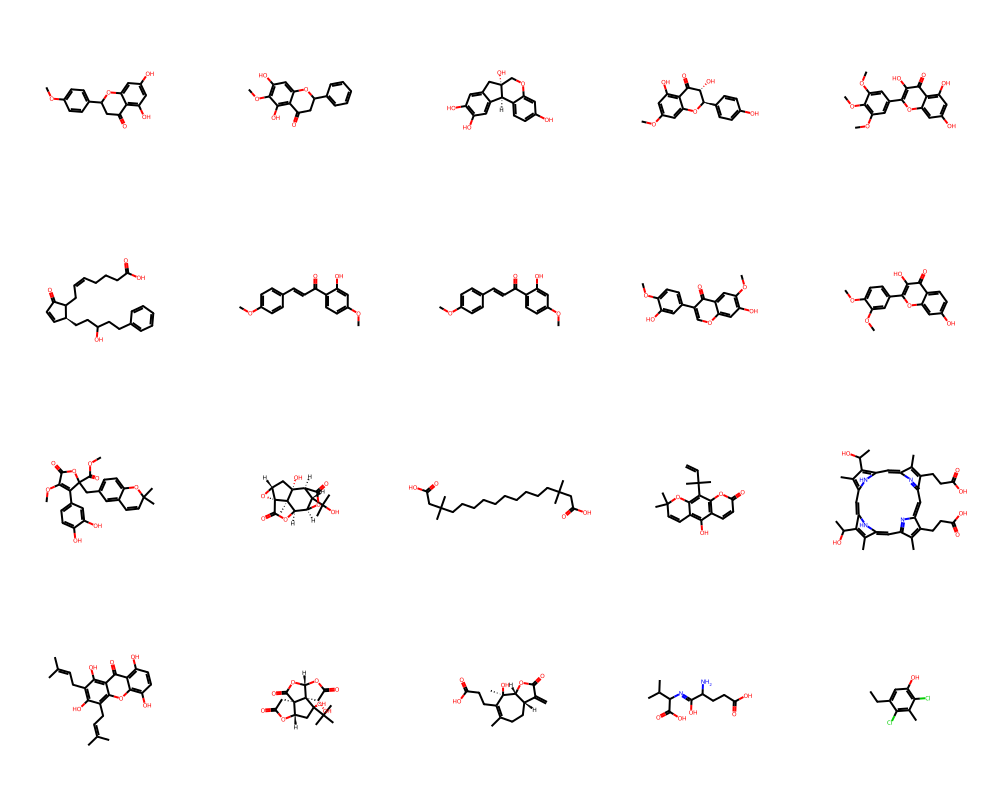

In [231]:
from rdkit import Chem
from rdkit.Chem import Draw
mz = nx.get_node_attributes(G, 'precursor_mz')
smiles_identity = nx.get_node_attributes(G, 'smiles_identity')
d = pd.merge(temp,pd.DataFrame({'precursor_mz':mz}),left_index=True,right_index=True)
d = pd.merge(d,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
p = d[pd.notna(d['smiles_identity'])]

p.sort_values('fold_change_cluster1-over2',ascending=False,inplace=True)
top_10 = p.head(10)
bottom_10 = p.tail(10)

top_mols = [Chem.MolFromSmiles(smiles) for smiles in top_10['smiles_identity']]
bottom_mols = [Chem.MolFromSmiles(smiles) for smiles in bottom_10['smiles_identity']]
mols = top_mols + bottom_mols
image = Draw.MolsToGridImage(mols, molsPerRow=5,maxMols=1000)
image

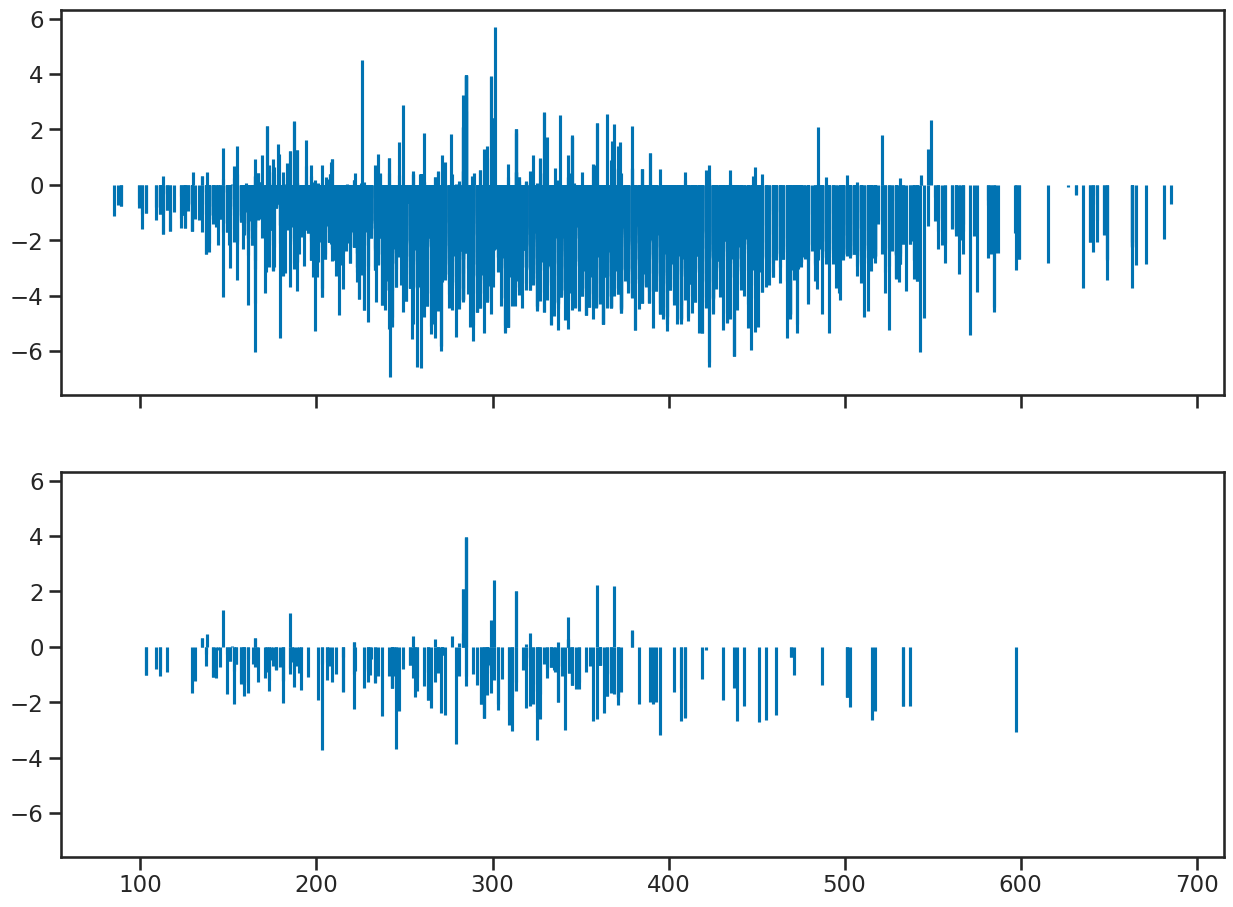

In [221]:
mz = nx.get_node_attributes(G, 'precursor_mz')
smiles_identity = nx.get_node_attributes(G, 'smiles_identity')
d = pd.merge(temp,pd.DataFrame({'precursor_mz':mz}),left_index=True,right_index=True)
d = pd.merge(d,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
# p = d[pd.notna(d['smiles_identity'])]
p = d.copy()
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(15,11),sharey=True,sharex=True)
ax[0].vlines(p['precursor_mz'], 0, p['fold_change_cluster1-over2'])


p = d[pd.notna(d['smiles_identity'])]
ax[1].vlines(p['precursor_mz'], 0, p['fold_change_cluster1-over2'])
# ax[2].vlines(p['precursor_mz'], 0, ymax=-1*(p[2]**0.5))


# for a in ax:
    # a.set_xlim(270,330)


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


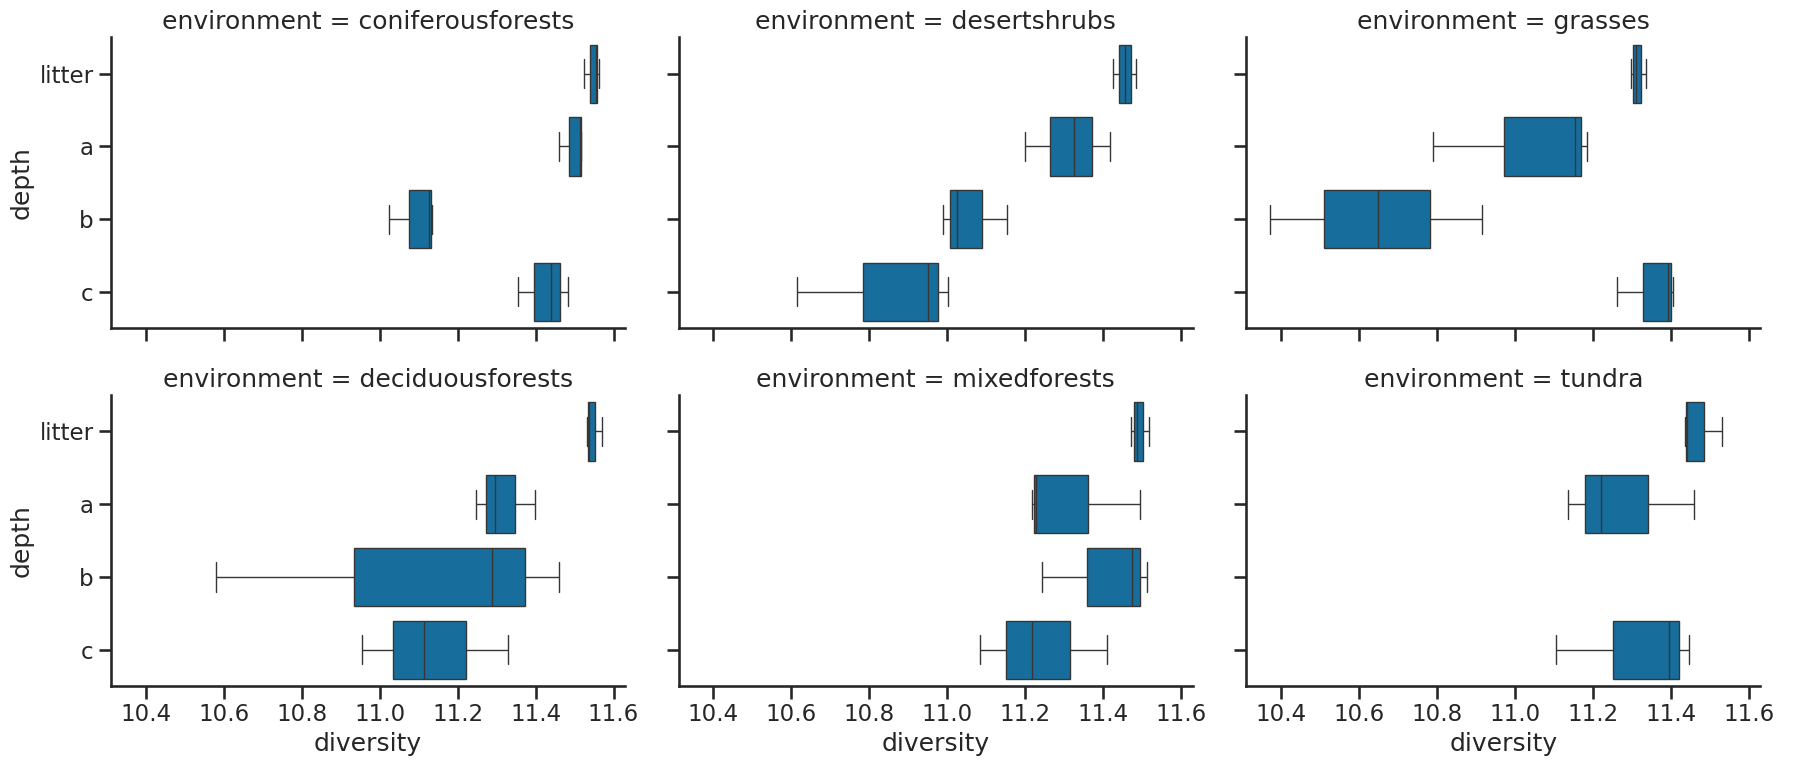

In [229]:
def shannon_diversity_index(m,threshold=1e6,q=2):
    m = m>threshold
    probabilities = m / m.sum()
    shannon_diversity_index = -np.sum(probabilities * np.log2(probabilities))
    return shannon_diversity_index
    # probabilities = m / m.sum()
    # hill_number = np.sum(probabilities**q)**(1/(1-q))
    # return hill_number

node_data = out.pivot_table(index='node_id',columns='filename',values='peak_area',aggfunc='sum',fill_value=300)
d = node_data.apply(shannon_diversity_index,axis=0)
d = d.to_frame()
d.reset_index(inplace=True,drop=False)
d.rename(columns={0:'diversity'},inplace=True)
d['sampletype'] = d['filename'].apply(lambda x: x.split('/')[-1].split('_')[12])
d['environment'] = d['sampletype'].apply(lambda x: x.split('-')[0])
d['depth'] = d['sampletype'].apply(lambda x: x.split('-')[1])

import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_style('ticks')
d['depth'] = pd.Categorical(d['depth'], categories=['litter', 'a', 'b', 'c'], ordered=True)

fig = sns.FacetGrid(data=d, col='environment', col_wrap=3, height=4,aspect=1.5,sharey=True,sharex=True)
                
fig.map(sns.boxplot, 'diversity', 'depth')
fig.add_legend()
# plt.show()
plt.tight_layout()
# fig,ax = plt.subplots(figsize=(10,10))
# # sns.boxplot(data=d, y='depth', x='shannon_diversity', hue='environment', ax=ax)
# # plt.legend(loc='upper left')
# # d

# sns.boxplot(data=d,y='depth',x='shannon_diversity',hue='environment',ax=ax)
# plt.legend(loc='upper left')
# # d


In [131]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)#, module="pingouin")
warnings.filterwarnings("ignore", category=RuntimeWarning)#, module="pingouin")


In [144]:
df = pd.merge(out,temp,left_on='node_id',right_index=True)

df = df[df['cluster']==i]
cols = ['environment', 'depth','peak_area','filename','node_id']
df = df[cols]
filename_mapping = {f: i+1 for i, f in enumerate(df['filename'].unique())}
df['filename'] = df['filename'].map(filename_mapping)

node_id_mapping = {f: i+1 for i, f in enumerate(df['node_id'].unique())}
df['node_id'] = df['node_id'].map(node_id_mapping)

df['peak_area'].fillna(300,inplace=True)

df = pd.pivot_table(df,values='peak_area',index=['filename','environment','depth'],columns=['node_id'],fill_value=300)
df = df.mean(axis=1).to_frame()
df.reset_index(inplace=True,drop=False)
df

,filename,environment,depth,0
0,1,deciduousforests,a,1.306208e+08
1,2,deciduousforests,litter,5.881760e+09
2,3,tundra,litter,1.134751e+09
3,4,desertshrubs,litter,6.743739e+08
4,5,coniferousforests,c,2.362027e+08
...,...,...,...,...
64,65,coniferousforests,b,3.739956e+07
65,66,mixedforests,litter,5.976825e+09
66,67,mixedforests,a,5.258663e+07
67,68,coniferousforests,c,1.440549e+08


In [129]:
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
smiles_identity = nx.get_node_attributes(G, 'smiles_identity')

temp = pd.DataFrame({'cluster':mcs_structural_cluster_number})
temp = pd.merge(temp,pd.DataFrame({'smiles':smiles_identity}),left_index=True,right_index=True)
temp.fillna('',inplace=True)
sig_out = []
val_out = []
for i in temp['cluster'].unique():
    df = pd.merge(out,temp,left_on='node_id',right_index=True)
    df = df[df['depth']!='litter']
    df = df[df['depth']!='b']
    df = df[(df['environment']=='coniferousforests') | (df['environment']=='grasses') ]
    df = df[df['cluster']==i]
    cols = ['environment', 'depth','peak_area','filename','node_id']
    df = df[cols]
    # filename_mapping = {f: i+1 for i, f in enumerate(df['filename'].unique())}
    # df['filename'] = df['filename'].map(filename_mapping)

    # node_id_mapping = {f: i+1 for i, f in enumerate(df['node_id'].unique())}
    # df['node_id'] = df['node_id'].map(node_id_mapping)



    df = pd.pivot_table(df,values='peak_area',index=['filename','environment','depth'],columns=['node_id'],fill_value=300)
    df = df.mean(axis=1).to_frame()
    df.reset_index(inplace=True,drop=False)
    # df = df.mean(axis=0).to_frame()
    # df = pd.melt(df.reset_index(),id_vars=['filename','environment','depth'],value_vars=df.columns)
    # anova_result = pg.rm_anova(data=df, dv='value', within=['environment', 'depth'], subject='filename')
    anova_result = pg.anova(data=df, dv=0, between=['environment', 'depth'])#, subject='filename')
    anova_result['structural_cluster'] = i
    sig_out.append(anova_result)
    v = df.groupby(['environment','depth'])[0].mean().to_frame().reset_index()
    v['structural_cluster'] = i
    val_out.append(v)
sig_out = pd.concat(sig_out)
val_out = pd.concat(val_out)
sig_out = pd.pivot_table(sig_out,values='p-unc',index=['structural_cluster'],columns=['Source'])
sig_out = sig_out[sig_out.min(axis=1)<0.05]
val_out = val_out.pivot_table(index='structural_cluster',columns=['environment','depth'],values=0)
val_out.columns = ['_'.join(c) for c in val_out.columns]
val_out.reset_index(inplace=True,drop=False)
sig_out = pd.merge(sig_out,val_out,left_index=True,right_on='structural_cluster',how='inner')

In [130]:

sig_out

,depth,environment,environment * depth,structural_cluster,coniferousforests_a,coniferousforests_c,grasses_a,grasses_c
1,0.022116,0.067785,0.741933,0,1.625784e+06,7.661924e+05,9.613584e+05,2.865528e+05
11,0.210057,0.032749,0.057508,10,3.427037e+08,1.845250e+08,1.308488e+08,1.685695e+08
14,0.060385,0.006602,0.009700,13,1.095204e+08,4.101279e+07,2.310521e+07,3.777576e+07
15,0.142424,0.041494,0.074996,14,5.491519e+07,1.847686e+07,1.055309e+07,1.470986e+07
16,0.018722,0.045190,0.018388,15,1.130828e+08,2.743721e+07,3.570650e+07,3.587724e+07
19,0.324853,0.018205,0.024558,18,9.530504e+07,4.733497e+07,2.331347e+07,4.488382e+07
20,0.772876,0.071463,0.038407,19,7.238818e+07,3.875965e+07,1.719887e+07,4.358742e+07
26,0.026573,0.286509,0.216225,25,1.474245e+08,5.464374e+07,9.057162e+07,5.923738e+07
28,0.070107,0.039952,0.265630,27,1.999893e+07,7.687428e+06,6.336483e+06,2.993201e+06
29,0.002306,0.620112,0.604337,28,1.022298e+07,3.353456e+06,1.026538e+07,1.473370e+06


In [128]:
pd.merge(sig_out,val_out,left_index=True,right_on='structural_cluster',how='inner')


,depth,environment,environment * depth,structural_cluster,coniferousforests_a,coniferousforests_c,grasses_a,grasses_c
1,0.022116,0.067785,0.741933,0,1.625784e+06,7.661924e+05,9.613584e+05,2.865528e+05
11,0.210057,0.032749,0.057508,10,3.427037e+08,1.845250e+08,1.308488e+08,1.685695e+08
14,0.060385,0.006602,0.009700,13,1.095204e+08,4.101279e+07,2.310521e+07,3.777576e+07
15,0.142424,0.041494,0.074996,14,5.491519e+07,1.847686e+07,1.055309e+07,1.470986e+07
16,0.018722,0.045190,0.018388,15,1.130828e+08,2.743721e+07,3.570650e+07,3.587724e+07
19,0.324853,0.018205,0.024558,18,9.530504e+07,4.733497e+07,2.331347e+07,4.488382e+07
20,0.772876,0.071463,0.038407,19,7.238818e+07,3.875965e+07,1.719887e+07,4.358742e+07
26,0.026573,0.286509,0.216225,25,1.474245e+08,5.464374e+07,9.057162e+07,5.923738e+07
28,0.070107,0.039952,0.265630,27,1.999893e+07,7.687428e+06,6.336483e+06,2.993201e+06
29,0.002306,0.620112,0.604337,28,1.022298e+07,3.353456e+06,1.026538e+07,1.473370e+06


In [111]:
df.groupby(['environment','depth'])[0].mean().to_frame().reset_index()

,environment,depth,0
0,coniferousforests,a,1.625784e+06
1,coniferousforests,c,7.661924e+05
2,grasses,a,9.613584e+05
3,grasses,c,2.865528e+05


In [104]:
sig_out.sort_values('depth',inplace=True)
sig_out.reset_index(inplace=True,drop=False)
sig_out

Source,structural_cluster,depth,environment,environment * depth
0,28,0.002306,0.620112,0.604337
1,15,0.018722,0.045190,0.018388
2,0,0.022116,0.067785,0.741933
3,25,0.026573,0.286509,0.216225
4,13,0.060385,0.006602,0.009700
5,27,0.070107,0.039952,0.265630
6,14,0.142424,0.041494,0.074996
7,10,0.210057,0.032749,0.057508
8,18,0.324853,0.018205,0.024558
9,19,0.772876,0.071463,0.038407


In [7]:
out.groupby(['environment'])['peak_area'].median().sort_values(ascending=False).head(20)


environment
coniferousforests    41440816.0
mixedforests         37807532.0
tundra               34577832.0
deciduousforests     27463349.0
desertshrubs         15450212.0
grasses              13879944.0
Name: peak_area, dtype: float64

In [100]:
node_data['coniferous_c_to_a'] = node_data['Quant: coniferousforests-c'] / node_data['Quant: coniferousforests-a']
node_data['grasses_c_to_a'] = node_data['Quant: grasses-c'] / node_data['Quant: grasses-a']
node_data['coniferous_c_to_a'] = node_data['coniferous_c_to_a'].apply(np.log2)
node_data['grasses_c_to_a'] = node_data['grasses_c_to_a'].apply(np.log2)
backup_G = G.copy()
nx.set_node_attributes(backup_G, node_data.to_dict('index'))
nx.write_graphml(backup_G,'../data/network_cornell-pnas.graphml')

In [94]:
node_data = pd.pivot_table(out,index=['node_id'],columns=['sampletype'],values='peak_area',aggfunc=np.mean,fill_value=300)
# node_data = node_data.apply(lambda  x: np.log10(x+1),axis=1)
# s = node_data.sum(axis=0).values
# m = s.mean()
# node_data.values[:,:] = m * (node_data.values[:,:]/s)
# node_data.columns = [c.split('/')[-1].split('_')[12] for c in node_data.columns]

# node_data.to_csv('../data/log10_averages_treatments.csv')
node_data
node_data.columns = ['Quant: %s'%c for c in node_data.columns]
backup_G = G.copy()
nx.set_node_attributes(backup_G, node_data.to_dict('index'))
nx.write_graphml(backup_G,'../data/network_cornell-pnas.graphml')

In [27]:
# sys.path.insert(0,'/global/homes/b/bpb/repos/blink')

# from blink.utils import filter_top_k, filter_component_additive

# # # # Filter edges by top k
# filter_top_k(G,20, edge_score='rem_predicted_score')
# # print(len(G.nodes))
# # print(len(G.edges))

# print(len(G.nodes))
# print(len(G.edges))

# # nx.write_graphml(G,'degree_5filtered.graphml')

# filter_component_additive(G, 75,edge_score='rem_predicted_score')


# # # Filter components by size
# for component in list(nx.connected_components(G)):
#     if len(component)<3:
#         for node in component:
#             G.remove_node(node)
# # # Remove self-loops
# G.remove_edges_from([(u, v) for u, v in G.edges() if u == v])    
            
# print(len(G.nodes))
# print(len(G.edges))

# nx.write_graphml(G,'../data/size75-degree20-with-intensity.graphml')

In [101]:
n = node_data.copy()
m = n.min(axis=1)
m = n.values - m.values[:,None]
n = pd.DataFrame(m,index=n.index,columns=n.columns)

m = n.max(axis=1)
m = n.values / m.values[:,None]
n = pd.DataFrame(m,index=n.index,columns=n.columns)


original_index = nx.get_node_attributes(G, 'original_index')
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
mcs_structural_pattern = nx.get_node_attributes(G, 'mcs_structural_pattern')
smiles_identity = nx.get_node_attributes(G, 'smiles_identity')
# temp = {}
# for c in n.columns:
    # temp[c] = nx.get_node_attributes(backup_G, c)

temp = pd.merge(n,pd.DataFrame({'cluster_id':mcs_structural_cluster_number}),left_index=True,right_index=True)
temp = pd.merge(temp,pd.DataFrame({'cluster_pattern':mcs_structural_pattern}),left_index=True,right_index=True)
temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
cols = [c for c in temp.columns if 'Quant' in c]
cluster_df = temp.groupby(['cluster_id','cluster_pattern'])[cols].mean()
identity_df = temp.groupby(['cluster_id','cluster_pattern','smiles_identity'])[cols].mean()


In [102]:
cluster_df

,,Quant: coniferousforests-a,Quant: coniferousforests-b,Quant: coniferousforests-c,Quant: coniferousforests-litter,Quant: deciduousforests-a,Quant: deciduousforests-b,Quant: deciduousforests-c,Quant: deciduousforests-litter,Quant: desertshrubs-a,Quant: desertshrubs-b,...,Quant: grasses-b,Quant: grasses-c,Quant: grasses-litter,Quant: mixedforests-a,Quant: mixedforests-b,Quant: mixedforests-c,Quant: mixedforests-litter,Quant: tundra-a,Quant: tundra-c,Quant: tundra-litter
cluster_id,cluster_pattern,,,,,,,,,,,,,,,,,,,,,
0,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])=&!@[#6&!R]-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#6&R]2:&@[#6&R]:&@[#8&R]:&@[#6&R]3:&@[#6&R](:&@[#6&R]:&@2=&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@3)-&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1-&!@[#8&!R],0.296655,0.132705,0.141118,0.528489,0.365296,0.101526,0.288061,0.225750,0.122100,0.129089,...,0.203791,0.051423,0.463696,0.267489,0.158619,0.143956,0.381710,0.388147,0.723941,1.000000
1,"[#7&R]:,-;@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1",0.073405,0.020335,0.056328,0.457873,0.052075,0.056561,0.060088,0.338505,0.074752,0.022943,...,0.012659,0.065829,0.935379,0.046090,0.053378,0.042914,0.211529,0.088514,0.055739,0.347927
2,[#6&!R]-&!@[#6&!R](-&!@[#8&!R])=&!@[#7&!R]-&!@[#6&!R](-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R],0.016867,0.005033,0.021423,0.334173,0.004575,0.026126,0.018459,0.276619,0.017727,0.005628,...,0.004145,0.019224,0.720035,0.006626,0.014971,0.021551,0.130203,0.023570,0.013565,0.128104
3,[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#7&R]:&@1,0.266347,0.266724,0.316552,0.513893,0.266410,0.345712,0.304901,0.636969,0.269629,0.282177,...,0.299605,0.324127,0.457690,0.231414,0.313589,0.334740,0.542198,0.294177,0.243174,0.862980
4,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R],0.458408,0.196768,0.276214,0.926191,0.195606,0.171749,0.195610,0.745217,0.121434,0.254263,...,0.067382,0.147891,0.105103,0.297613,0.249723,0.166262,0.369193,0.332368,0.410983,0.358928
5,[#6&!R]-&!@[#6&R]1-&@[#6&R]-&@[#6&R]-&@[#6&R]2(-&@[#6&R](-&@[#6&R]-&@1)-&@[#6&R]-&@[#6&R](-&@[#6&R]-&@[#6&R]-&@2)-&@[#6&R](-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R](-&!@[#6&!R])-&!@[#6&!R])(-&!@[#6&!R])-&@[#6&R]-&@[#6&R]-&@[#6&R])-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R],0.223823,0.173542,0.049043,0.226970,0.186424,0.087391,0.080396,0.895625,0.044975,0.011180,...,0.009598,0.044576,0.004871,0.193892,0.293078,0.231997,0.446464,0.105060,0.131185,0.420958
6,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])=&!@[#6&!R]-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R](-&!@[#8&!R]):&@[#6&R](-&!@[#6&!R]-&!@[#6&!R]=&!@[#6&!R](-&!@[#6&!R])-&!@[#6&!R]):&@[#6&R]2:&@[#6&R](:&@[#6&R]:&@1-&!@[#8&!R]):&@[#6&R](:&@[#6&R]1:&@[#6&R](:&@[#8&R]:&@2):&@[#6&R](-&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)=&!@[#8&!R],0.096934,0.148009,0.151944,0.073178,0.075696,0.115032,0.079261,0.164734,0.084328,0.134049,...,0.173509,0.076625,0.069861,0.027161,0.165335,0.077700,0.069140,0.178706,0.107703,0.069627
7,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#8&!R]):&@[#7&R]:&@[#6&R](:&@[#6&R]:&@1)-&!@[#8&!R],0.103812,0.015056,0.061921,0.649046,0.019586,0.046735,0.024055,0.970558,0.038881,0.020547,...,0.019451,0.045716,0.148854,0.030199,0.115450,0.050357,0.548182,0.031363,0.033906,0.570174
8,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R],0.288530,0.117429,0.251744,0.742476,0.103743,0.382735,0.192737,0.548665,0.186127,0.167270,...,0.236515,0.230531,0.231891,0.153653,0.335330,0.448272,0.424210,0.224877,0.179920,0.399461


In [199]:
temp

,Quant: coniferousforests-a,Quant: coniferousforests-b,Quant: coniferousforests-c,Quant: deciduousforests-a,Quant: deciduousforests-b,Quant: deciduousforests-c,Quant: desertshrubs-a,Quant: desertshrubs-b,Quant: desertshrubs-c,Quant: grasses-a,Quant: grasses-b,Quant: grasses-c,Quant: mixedforests-a,Quant: mixedforests-b,Quant: mixedforests-c,Quant: tundra-a,Quant: tundra-c
cluster_id,,,,,,,,,,,,,,,,,
1,0.142128,0.215125,0.156839,0.269762,0.308071,0.471012,0.357875,0.279713,0.333890,0.488748,0.334900,0.224663,0.169433,0.051564,0.192573,0.371629,0.231758
13,0.633577,0.688808,0.572630,0.824650,0.615494,0.735198,0.573871,0.485911,0.422057,0.435191,0.448624,0.605118,0.590609,0.501818,0.412552,0.410814,0.601557
15,0.479512,0.531432,0.223676,0.663729,0.615942,0.684462,0.536298,0.697160,0.728838,0.522512,0.632762,0.281466,0.626676,0.377725,0.325641,0.707043,0.702754
16,0.435785,0.758943,0.308886,0.698136,0.175635,0.452508,0.319160,0.414378,0.568461,0.675029,0.381764,0.197506,0.636021,0.378978,0.340726,0.520840,0.550587
22,0.352753,0.432584,0.558848,0.548153,0.341473,0.391249,0.383419,0.277096,0.649164,0.449718,0.332172,0.405576,0.521505,0.273170,0.239120,0.671106,0.119024
26,0.228074,0.355743,0.190615,0.188915,0.286737,0.389265,0.268191,0.479356,0.420819,0.501217,0.498547,0.314518,0.206172,0.282045,0.306671,0.440789,0.245039
27,0.656163,0.415943,0.453593,0.563854,0.417205,0.371063,0.526625,0.487397,0.382617,0.451023,0.230737,0.350179,0.647835,0.533301,0.521202,0.586844,0.595941
28,0.510997,0.588364,0.329682,0.784375,0.342639,0.581675,0.702078,0.691699,0.573934,0.862146,0.402601,0.084240,0.687408,0.290837,0.454861,0.692181,0.771035


In [237]:
sig_out

Source,structural_cluster,depth,environment,environment * depth
0,28,0.001747,0.334384,0.969923
1,27,0.004737,0.029864,0.625283
2,22,0.005156,0.067013,0.328280
3,1,0.009196,0.424317,0.373154
4,15,0.010532,0.379658,0.569065
5,13,0.013517,0.072216,0.211515
6,16,0.017112,0.716195,0.806048
7,26,0.042227,0.369251,0.698646
8,20,0.055063,0.035864,0.411622
9,2,0.075225,0.282097,0.026414


In [69]:
temp = cluster_df.copy()
cols = [c for c in temp.columns if 'litter' not in c]
temp = temp[cols]
temp.reset_index(inplace=True,drop=False)
temp.set_index('cluster_id',inplace=True,drop=True)
temp.drop(columns=['cluster_pattern'],inplace=True)
# temp = temp[temp.index.isin(sig_out.loc[sig_out['depth']<0.05,'structural_cluster'].values)].copy()
temp = temp[temp.index.isin(sig_out.loc[sig_out['depth']<0.05,'structural_cluster'])].copy()

In [85]:
df

cluster_id,index,15,25,28,sampletype,environment,depth
0,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.042304,0.013217,0.046951,coniferousforests-a,coniferousforests,a
2,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.024181,0.007027,0.021958,coniferousforests-c,coniferousforests,c
3,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.071763,0.022113,0.085514,coniferousforests-a,coniferousforests,a
5,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.009764,0.004192,0.005120,coniferousforests-c,coniferousforests,c
6,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.050149,0.023813,0.089077,coniferousforests-a,coniferousforests,a
8,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.042135,0.007314,0.033751,coniferousforests-c,coniferousforests,c
10,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.024805,0.021904,0.088758,grasses-a,grasses,a
32,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.018107,0.007926,0.009466,grasses-c,grasses,c
43,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.024266,0.006732,0.071904,grasses-a,grasses,a
47,Quant: /global/cfs/cdirs/metatlas/raw_data/egs...,0.005263,0.002466,0.001714,grasses-c,grasses,c


<Axes: xlabel='28', ylabel='environment'>

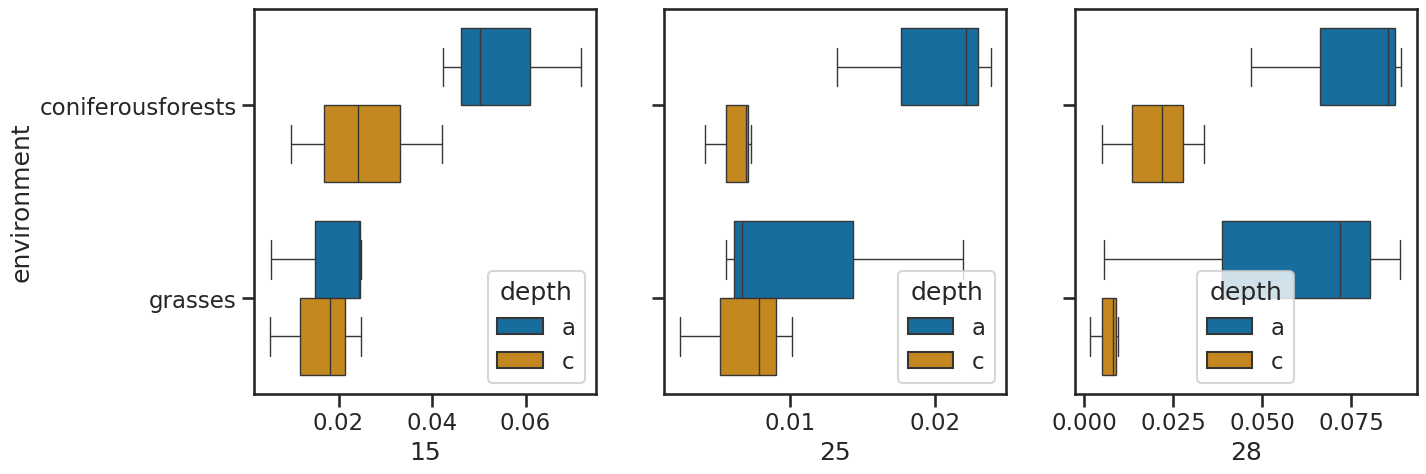

In [87]:
df = temp.T.copy()
df.reset_index(inplace=True,drop=False)
df['sampletype'] = df['index'].apply(lambda x: os.path.basename(x).split('_')[12])
df['environment'] = df['sampletype'].apply(lambda x: x.split('-')[0])
df['depth'] = df['sampletype'].apply(lambda x: x.split('-')[1])
e = ['coniferousforests','grasses']
d = ['a','c']
df = df[df['environment'].isin(e)]
df = df[df['depth'].isin(d)]
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(15,5),sharey=True)
sns.boxplot(data=df,y='environment',x=15,hue='depth',ax=ax[0])
sns.boxplot(data=df,y='environment',x=25,hue='depth',ax=ax[1])
sns.boxplot(data=df,y='environment',x=28,hue='depth',ax=ax[2])


In [77]:
model = sm.OLS(x[:,0], x[:,1])
result = model.fit()
slope = result.params[0]
slope


array([0.20858426])

In [78]:
import itertools
import statsmodels.api as sm

# Generate all combinations of row indices
row_indices = temp.index.tolist()
combinations = list(itertools.combinations(row_indices, 2))

# Perform linear regression for each combination
results = []
selected_combinations = []
for combination in combinations:
    x = temp.loc[[combination[0], combination[1]]].T.values
    # x = sm.add_constant(x)
    # y = temp.columns.tolist()
    model = sm.OLS(x[:,0], x[:,1])
    result = model.fit()
    # if result.rsquared > 0.8:
    results.append(result)
    selected_combinations.append(combination)

# Print the selected combinations and their corresponding results
for i, combination in enumerate(selected_combinations):
    print(f"Combination {i+1}: {combination}, slope: {results[i].params[0]}, r-squared: {results[i].rsquared}")
    # print(results[i].summary())
    print()


Combination 1: (15, 25), slope: 2.8067447201209212, r-squared: 0.6925799158131096

Combination 2: (15, 28), slope: 0.7163169290578615, r-squared: 0.7225477724963751

Combination 3: (25, 28), slope: 0.20858426163101093, r-squared: 0.6968754166412527



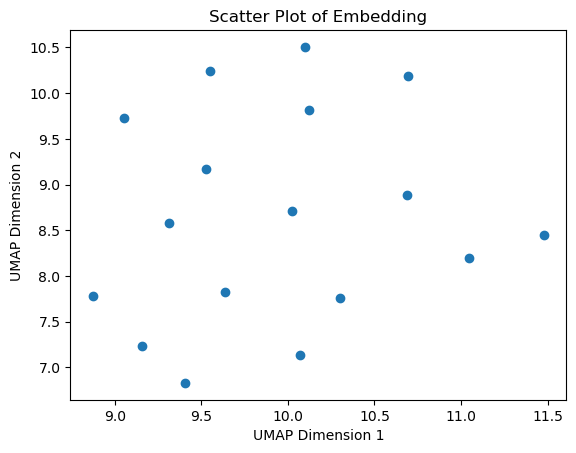

In [249]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(temp.T)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Label the datapoints with column labels
for i, label in enumerate(temp.columns):
    ax.annotate(label, (tsne_results[i, 0], tsne_results[i, 1]))

plt.show()



In [240]:
import umap
import matplotlib.pyplot as plt



# Reduce dimensionality using UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(temp.T)


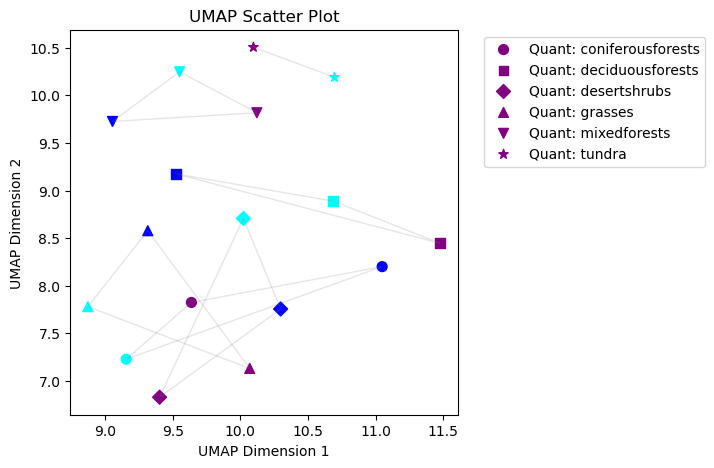

In [241]:

shape_mapping = {'Quant: coniferousforests':'o', 'Quant: deciduousforests':'s',
    'Quant: desertshrubs':'D', 'Quant: grasses':'^', 'Quant: mixedforests':'v',
    'Quant: tundra':'*'}

colors = [col.split('-')[1] for col in temp.columns]
shapes = [col.split('-')[0] for col in temp.columns]
color_mapping = {'a': 'purple', 'b': 'blue', 'c': 'cyan'}  # Add your color mapping here

# Convert categorical values to actual shapes
actual_shapes = [shape_mapping[shape] for shape in shapes]

# Convert categorical values to actual colors
actual_colors = [color_mapping[color] for color in colors]


# fig, ax = plt.subplots(figsize=(5, 5))
# for i in range(embedding.shape[0]):
#     ax.scatter(embedding[i, 0], embedding[i, 1],s=50, c=actual_colors[i], marker=actual_shapes[i], label='%s-%s' % (shapes[i], colors[i]))

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig, ax = plt.subplots(figsize=(5, 5))

# Group the markers by shape
shape_groups = temp.columns.to_series().groupby(shapes)

for shape, group in shape_groups:
    # Get the indices of the markers with the same shape
    indices = [i for i, col in enumerate(temp.columns) if col.split('-')[0] == shape]
    
    # Get the colors of the markers with the same shape
    shape_colors = [actual_colors[i] for i in indices]
    
    # Get the coordinates of the markers with the same shape
    shape_coords = embedding[indices]
    
    # Draw shaded regions around markers with the same shape
    ax.scatter(shape_coords[:, 0], shape_coords[:, 1], s=50, c=shape_colors, marker=shape_mapping[shape], label=shape)
    ax.fill(shape_coords[:, 0], shape_coords[:, 1], facecolor='none', edgecolor='gray', alpha=0.2)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Scatter Plot')
plt.show()


# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.title('UMAP Scatter Plot')
# plt.show()



In [251]:
import umap
from sklearn.mixture import GaussianMixture

# Define a function to calculate variable importance and remove rows iteratively
def calculate_variable_importance(temp):
    # Reduce dimensionality using UMAP
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(temp)

    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2)
    gmm.fit(embedding)

    # Calculate AIC and BIC for each row
    aic_scores = gmm.aic(temp)
    bic_scores = gmm.bic(temp)

    # Assign variable importance based on AIC and BIC scores
    temp['variable_importance_aic'] = aic_scores
    temp['variable_importance_bic'] = bic_scores

    # Sort rows by variable importance (AIC or BIC)
    temp.sort_values(by=['variable_importance_aic', 'variable_importance_bic'], ascending=[False, False], inplace=True)

# Remove rows iteratively based on variable importance
removed_rows = []
for index, row in temp.iterrows():
    temp.drop(index, inplace=True)
    # Re-calculate variable importance after removing a row
    calculate_variable_importance(temp)
    # Check if any remaining rows have lower variable importance
    if temp['variable_importance_aic'].max() < row['variable_importance_aic'] or temp['variable_importance_bic'].max() < row['variable_importance_bic']:
        removed_rows.append(index)
    else:
        temp.loc[index] = row  # Add the removed row back if it still has high variable importance

# Remove the rows with low variable importance
temp.drop(removed_rows, inplace=True)

# Call the function to calculate variable importance and remove rows iteratively
calculate_variable_importance(temp)


ValueError: X has 5 features, but GaussianMixture is expecting 2 features as input.

In [ ]:
# Reduce dimensionality using UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(temp.T)

# Create scatter plot
plt.scatter(embedding[:, 0], embedding[:, 1])

# Add column labels to the points
for i, label in enumerate(x_labels):
    plt.annotate(label, (embedding[i, 0], embedding[i, 1]))

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Scatter Plot')
plt.show()


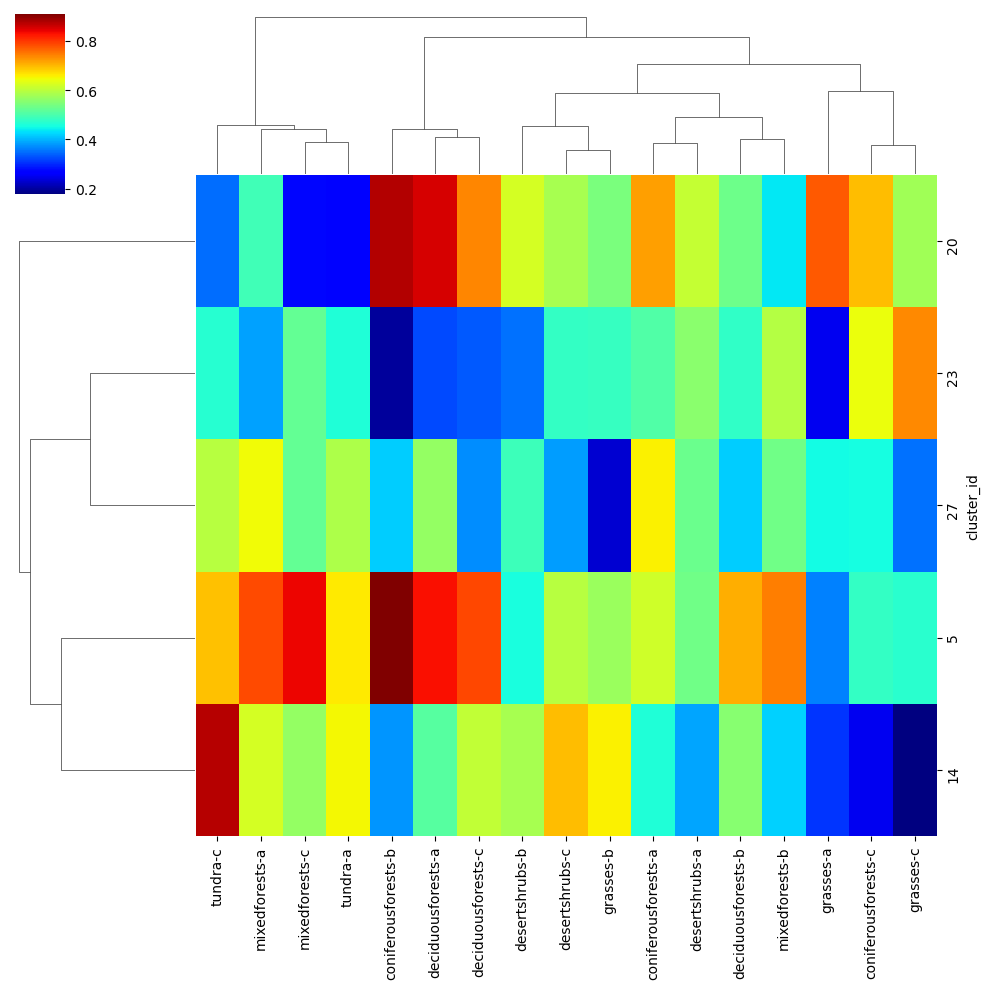

In [189]:
import seaborn as sns
cols = identity_df.columns
c = 0
x_labels = [col.replace('Quant: ','') for col in cols]
from PIL import Image
from io import BytesIO
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)
temp = cluster_df.copy()
cols = [c for c in temp.columns if 'litter' not in c]
temp = temp[cols]
temp.reset_index(inplace=True,drop=False)
temp.set_index('cluster_id',inplace=True,drop=True)
temp.drop(columns=['cluster_pattern'],inplace=True)
temp = temp[temp.index.isin(sig_out.loc[sig_out['environment']<0.05,'structural_cluster'].values)].copy()

num_unique_clusters = temp.shape[0]


# temp.reset_index(inplace=True,drop=True)
temp.columns = [c.replace('Quant: ','') for c in temp.columns]
# temp = temp.apply(lambda x: x/x.sum(),axis=1)
# fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,20))
                      
sns.clustermap(temp,cmap='jet',method='ward')
#     ax[c].set_title('Cluster %d'%d.iloc[0]['cluster_id'])
#     counter = 0
#     for i, row in d.iterrows():

#         mol = Chem.MolFromSmiles(row['smiles_identity'])
#         d2d = Draw.MolDraw2DCairo(120, 120)
#         dopts = d2d.drawOptions()
#         dopts.setBackgroundColour((0, 0, 0, 0))
#         im = show_mol(d2d, mol)

#         imagebox = OffsetImage(im, zoom=0.8)
#         ax[c].add_artist(AnnotationBbox(imagebox, (-1, counter+0.5), frameon=False,annotation_clip=False))#,box_alignment=(0,0)))
        
#         counter += 1
#     c += 1
#     # if c>6:
#         # break
    
# plt.tight_layout()

# # Set the x-axis labels for the bottom row of subplots
# for i in range(n_cols):
#     ax[-n_cols + i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

# # Set the x-axis label for the entire figure
# # fig.text(0.5, 0.04, 'Identity', ha='center', fontsize=14)

# plt.tight_layout()
# fig.savefig('../data/identity_heatmap_cornel-pnas.pdf')

# cluster_df

27


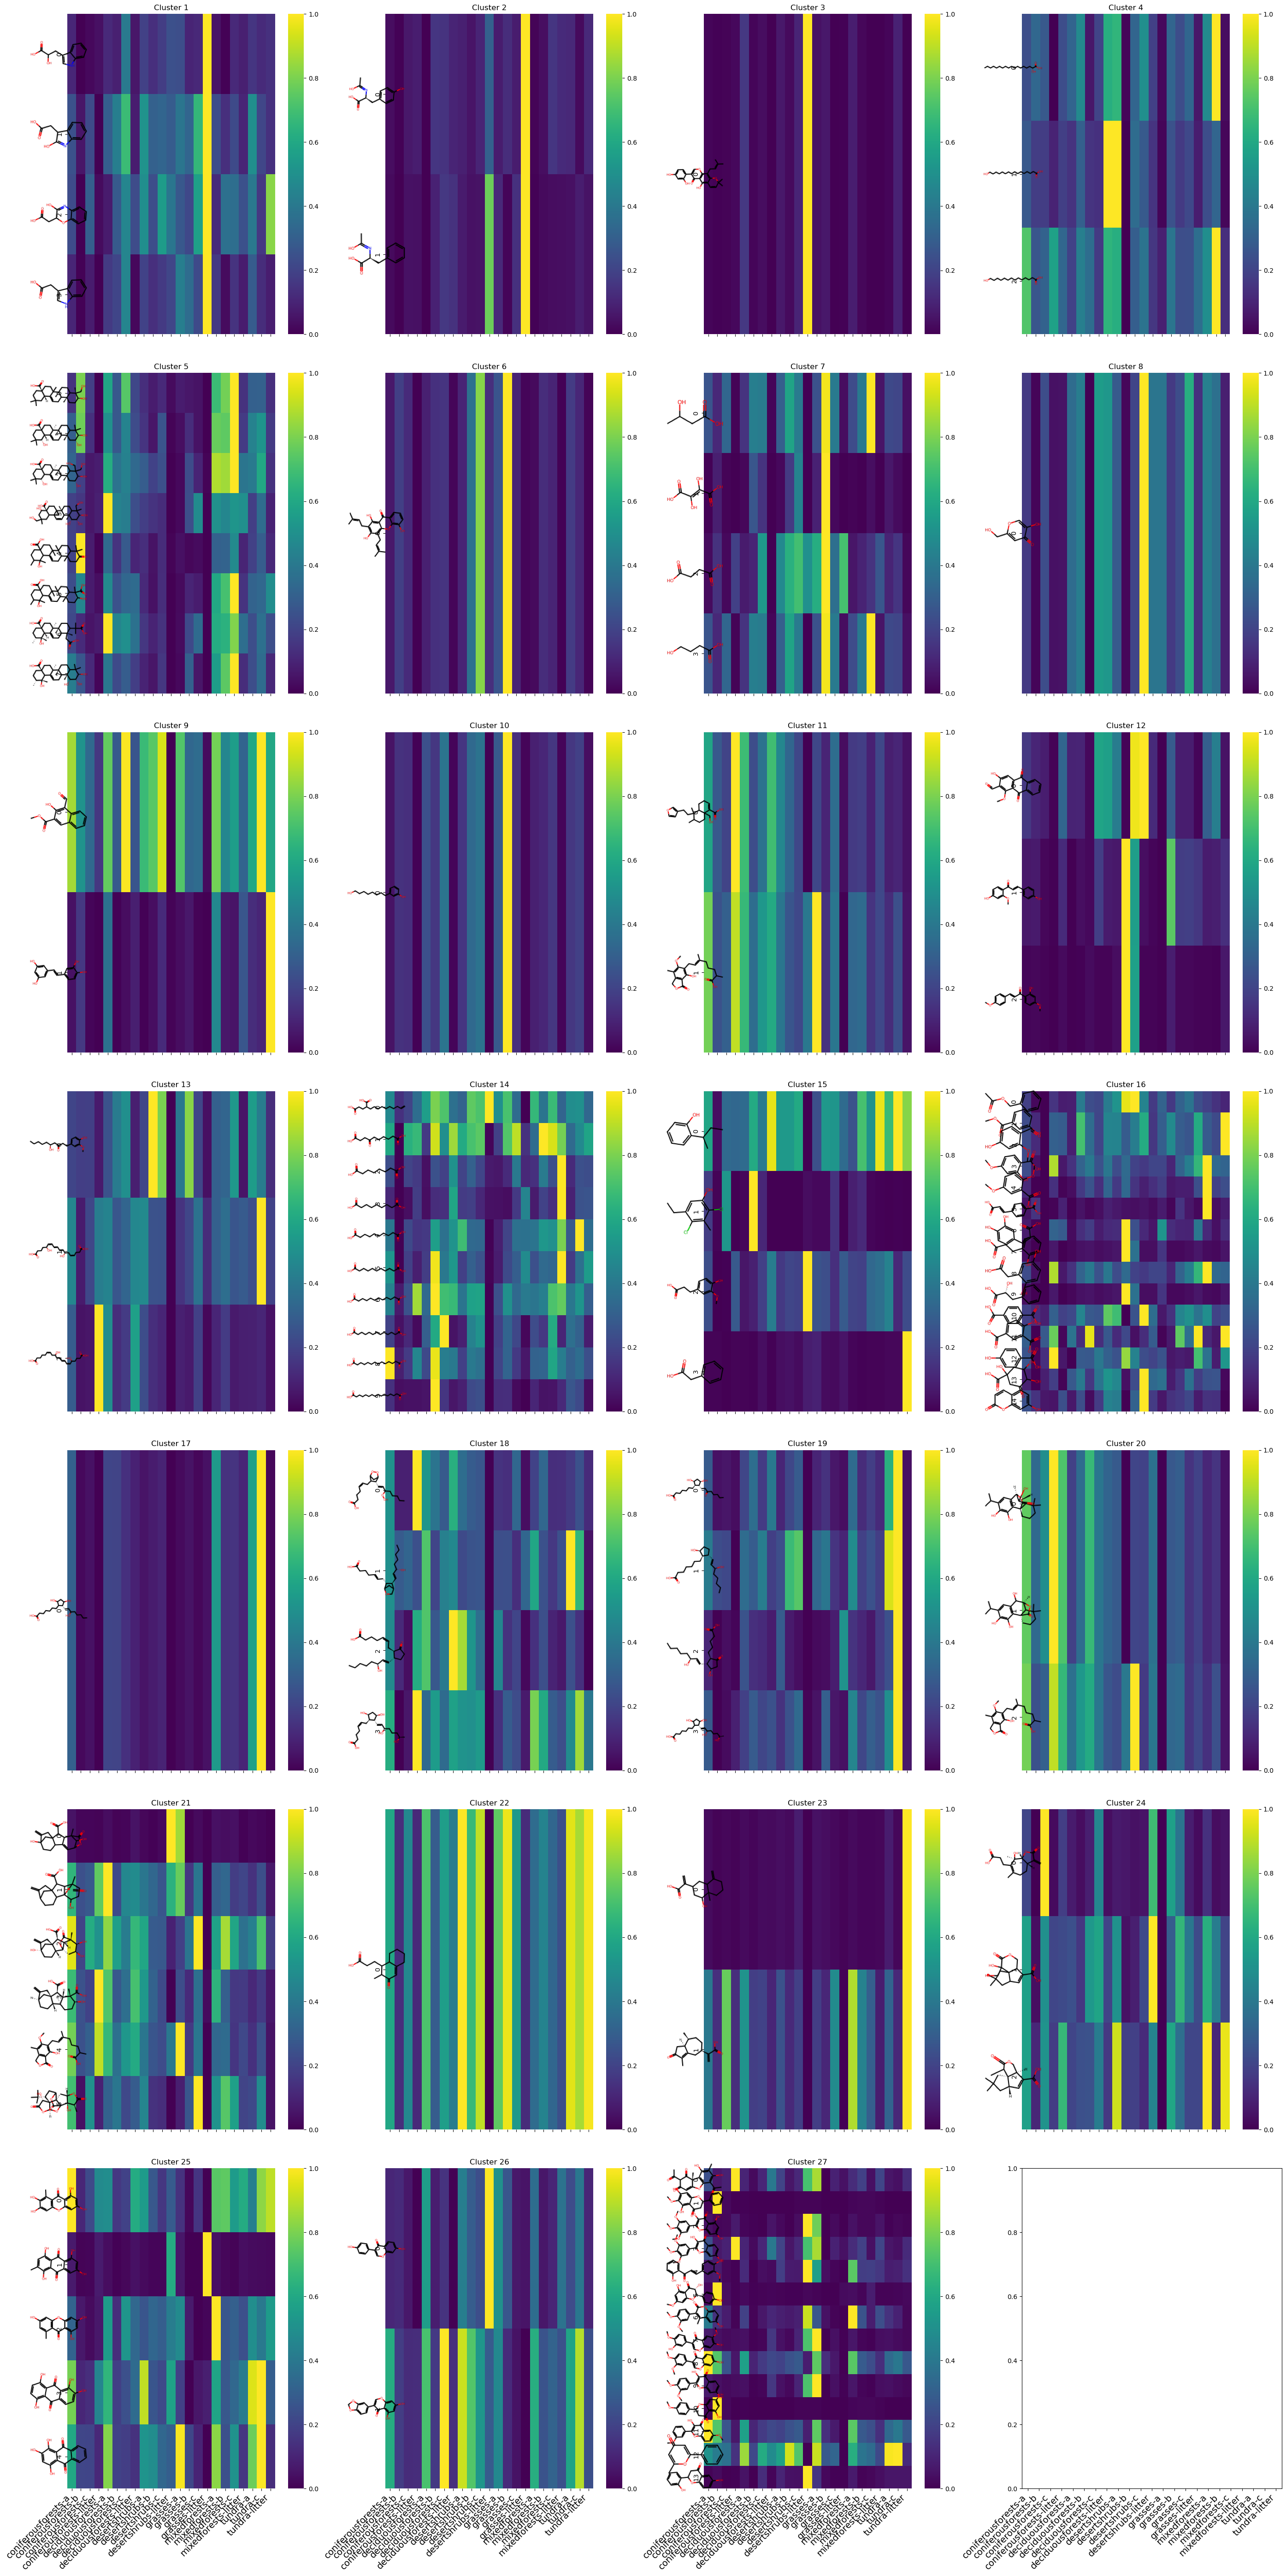

In [12]:
import seaborn as sns
cols = identity_df.columns
c = 0
x_labels = [col.replace('Quant: ','') for col in cols]
from PIL import Image
from io import BytesIO
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

num_unique_clusters = identity_df.index.get_level_values('cluster_id').nunique()
print(num_unique_clusters)
n_cols = 4
n_rows = int(np.ceil(num_unique_clusters/n_cols))

fig,ax = plt.subplots(nrows=n_rows,ncols=4,figsize=(n_rows*4,n_cols*14),sharex=True,sharey=False)
                      
ax = ax.flatten()
for _,d in identity_df.reset_index(drop=False).groupby('cluster_id'):
    
    sns.heatmap(d[cols].values,ax=ax[c],cmap='viridis')
    ax[c].set_title('Cluster %d'%d.iloc[0]['cluster_id'])
    counter = 0
    for i, row in d.iterrows():

        mol = Chem.MolFromSmiles(row['smiles_identity'])
        d2d = Draw.MolDraw2DCairo(120, 120)
        dopts = d2d.drawOptions()
        dopts.setBackgroundColour((0, 0, 0, 0))
        im = show_mol(d2d, mol)

        imagebox = OffsetImage(im, zoom=0.8)
        ax[c].add_artist(AnnotationBbox(imagebox, (-1, counter+0.5), frameon=False,annotation_clip=False))#,box_alignment=(0,0)))
        
        counter += 1
    c += 1
    # if c>6:
        # break
    
plt.tight_layout()

# Set the x-axis labels for the bottom row of subplots
for i in range(n_cols):
    ax[-n_cols + i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

# Set the x-axis label for the entire figure
# fig.text(0.5, 0.04, 'Identity', ha='center', fontsize=14)

plt.tight_layout()
fig.savefig('../data/identity_heatmap_cornel-pnas.pdf')


In [60]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the pairwise distances between rows
cols = [c for c in cluster_df.columns if ('deciduousforests' in c) | ('coniferousforests' in c)]
distances = cluster_df.values

# Perform hierarchical clustering
Z = linkage(distances, method='average', metric='euclidean')

# Get the order of the rows based on the clustering
order = dendrogram(Z, no_plot=True)['leaves']

# Reorder the rows of cluster_df
cluster_df = cluster_df.iloc[order]

# Show the reordered cluster_df
cluster_df[cols]


,,Quant: coniferousforests-a,Quant: coniferousforests-b,Quant: coniferousforests-c,Quant: coniferousforests-litter,Quant: deciduousforests-a,Quant: deciduousforests-b,Quant: deciduousforests-c,Quant: deciduousforests-litter
cluster_id,cluster_pattern,,,,,,,,
22,[#6&!R]=&!@[#6&!R](-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R])-&!@[#6&R](-&@[#6&R]-&@[#6&R]-&@[#6&R]-&!@[#6&!R])-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R],0.352753,0.432584,0.558848,0.233376,0.548153,0.341473,0.391249,0.172509
28,[#8&!R]=&!@[#6&R]1:&@[#6&R](-&!@[#6&R]2:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@2):&@[#6&R]:&@[#8&R]:&@[#6&R]2:&@[#6&R]:&@1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@2)-&!@[#8&!R],0.510997,0.588364,0.329682,0.299193,0.784375,0.342639,0.581675,0.221493
16,[#8&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#8&!R]):&@[#6&R]:&@[#6&R](:&@[#6&R]:&@1)-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R](:&@[#6&R]:&@1)-&!@[#8&!R])-&!@[#8&!R],0.435785,0.758943,0.308886,0.346499,0.698136,0.175635,0.452508,0.542307
17,[#8&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1-&!@[#6&!R](=&!@[#8&!R])-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@[#6&R]:&@1)-&!@[#8&!R],0.262641,0.478596,0.246815,0.147522,0.402201,0.000000,0.201602,0.326508
29,"[#6&R](-,:;@[#6&R]-,:;@[#6&R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)-,:;@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]",0.448468,0.642493,0.474529,0.360398,0.432937,0.260155,0.324238,0.420645
5,[#6&!R]-&!@[#6&R]1-&@[#6&R]-&@[#6&R]-&@[#6&R]2(-&@[#6&R](-&@[#6&R]-&@1)-&@[#6&R]-&@[#6&R](-&@[#6&R]-&@[#6&R]-&@2)-&@[#6&R](-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R](-&!@[#6&!R])-&!@[#6&!R])(-&!@[#6&!R])-&@[#6&R]-&@[#6&R]-&@[#6&R])-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R],0.617100,0.908647,0.479358,0.274717,0.828871,0.706754,0.787592,0.598484
20,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R](:&@[#6&R]:&@1-&!@[#8&!R])-&!@[#8&!R])-&@[#6&R]1(-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R](-&@[#6&R]-&@1)(-&!@[#6&!R])-&!@[#6&!R])-&@[#6&R](-&@[#8&R]-&@[#6&R]-&@[#6&R]-&!@[#8&!R])=&!@[#8&!R],0.717646,0.876937,0.697466,0.926791,0.853436,0.529418,0.739541,0.691915
14,[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&R]1-&@[#6&R](-&!@[#8&!R])-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@1-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R],0.463350,0.376833,0.252175,0.574308,0.510874,0.554562,0.604438,0.484727
15,[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&R]1-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@1-&!@[#6&!R]-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R],0.479512,0.531432,0.223676,0.731060,0.663729,0.615942,0.684462,0.557094


In [71]:
X

array([[0.        , 0.1517823 ],
       [0.01820346, 0.09378591],
       [0.14752172, 0.32650793],
       [0.15322819, 0.11647638],
       [0.18375165, 0.07533162],
       [0.18584564, 0.21711498],
       [0.19393477, 0.13607873],
       [0.20796583, 0.22048184],
       [0.23337573, 0.17250905],
       [0.27471707, 0.5984838 ],
       [0.29919257, 0.22149301],
       [0.31368427, 0.14270419],
       [0.31647659, 0.34771622],
       [0.32273487, 0.33485659],
       [0.34649859, 0.54230661],
       [0.36039766, 0.42064533],
       [0.38729162, 0.35341481],
       [0.40015129, 0.48007851],
       [0.48951501, 0.40138409],
       [0.53350194, 0.66460197],
       [0.54042921, 0.48435572],
       [0.54564604, 0.51645713],
       [0.57430751, 0.48472693],
       [0.61194921, 0.51527161],
       [0.62346483, 0.57032746],
       [0.62522843, 0.58805734],
       [0.67345078, 0.64129989],
       [0.73105995, 0.5570944 ],
       [0.92679136, 0.69191462]])

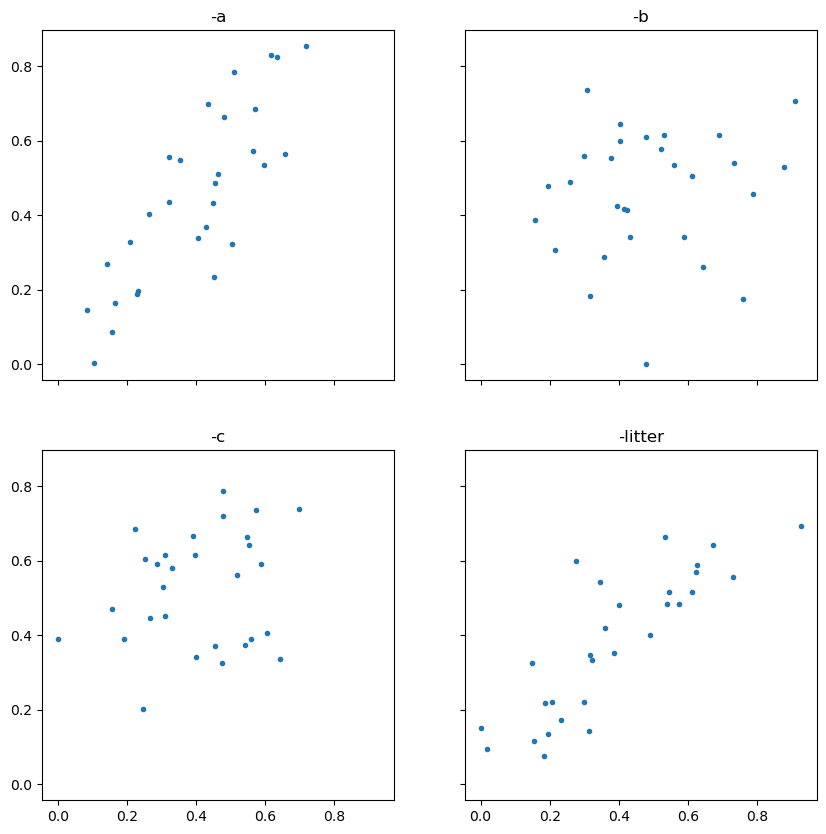

In [74]:
cols = [c for c in cluster_df.columns if ('deciduousforests' in c) | ('coniferousforests' in c)]
temp = cluster_df[cols].copy()
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,10),sharex=True,sharey=True)
ax = ax.flatten()
counter = 0
for depth in ['-a','-b','-c','-litter']:
    cols = [c for c in temp.columns if depth in c]
    X = temp[cols].values
    idx = np.argsort(X[:,0])
    X = X[idx,:]
    ax[counter].plot(X[:,0],X[:,1],'.',label=depth)
    ax[counter].set_title(depth)
    counter += 1
# ax.legend()

In [9]:
cluster_df.shape

NameError: name 'cluster_df' is not defined

In [8]:
import pingouin as pg

# Assuming you have a DataFrame called 'data' with columns: 'Metabolite', 'Treatment', 'Timepoint', and 'Value'
# 'Metabolite' column contains the names of the metabolites
# 'Treatment' column contains the treatment groups (e.g., 'Treatment A', 'Treatment B')
# 'Timepoint' column contains the timepoints (e.g., 'Timepoint 1', 'Timepoint 2')
# 'Value' column contains the observed values for each metabolite, treatment, and timepoint
data = {
    'Gene': [1,1,2,2,1,1,2,2],
    'Subject': ['Subject1', 'Subject2', 'Subject1', 'Subject2', 'Subject1', 'Subject2', 'Subject1', 'Subject2'],
    'Treatment': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'B'],
    'Timepoint': ['T1', 'T1', 'T1', 'T1', 'T2', 'T2', 'T2', 'T2'],
    'Value': [10, 12, 15, 14, 18, 20, 22, 24]
}

df = pd.DataFrame(data)



anova_result = pg.rm_anova(data=df, dv='Value', within=['Treatment', 'Timepoint'], subject='Subject')

# Print ANOVA results
print("Repeated Measures ANOVA Results:")
print(anova_result)


                  Source       SS  DF       MS          F     p-unc       np2
0              Treatment   28.125   1   28.125  17.307692  0.014142  0.812274
1              Timepoint  136.125   1  136.125  83.769231  0.000791  0.954426
2  Treatment * Timepoint    0.125   1    0.125   0.076923  0.795255  0.018868
3               Residual    6.500   4    1.625        NaN       NaN       NaN






Repeated Measures ANOVA Results:
                  Source       SS  ddof1  ddof2       MS           F  \
0              Treatment   28.125      1      1   28.125   25.000000   
1              Timepoint  136.125      1      1  136.125  121.000000   
2  Treatment * Timepoint    0.125      1      1    0.125    0.111111   

      p-unc  p-GG-corr       np2  eps  
0  0.125666   0.125666  0.961538  1.0  
1  0.057716   0.057716  0.991803  1.0  
2  0.795167   0.795167  0.100000  1.0  


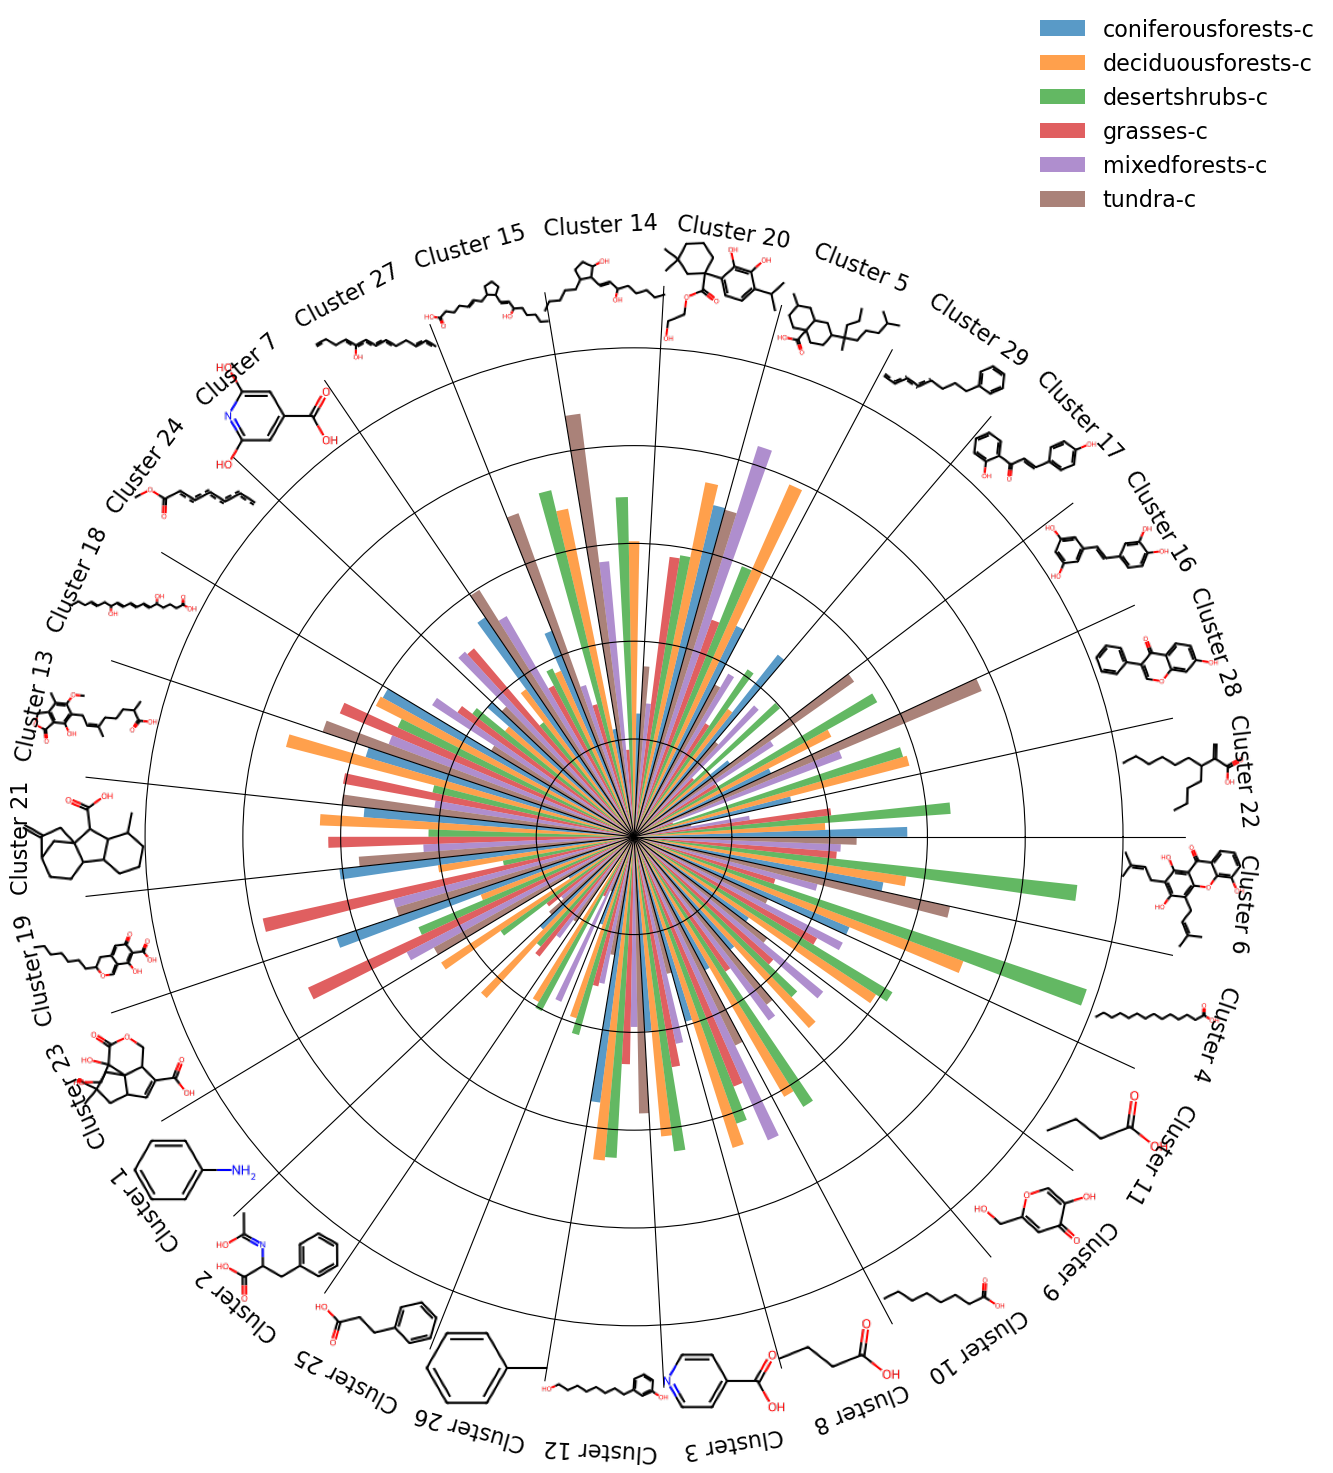

In [79]:
# Create the polar plot
def make_polar_structural_cluster_plot(cluster_df,file_str=''):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15), subplot_kw={'projection': 'polar'})

    # Define the angles for each side of the polygons
    angles = np.linspace(0, 2 * np.pi, cluster_df.shape[0] + 1)[:-1]
    shift_amount = np.diff(angles)[0] / cluster_df.shape[1]
    for iii in range(cluster_df.shape[1]):
        # Define the lengths of the bars
        bar_lengths = cluster_df.values[:, iii]
        # Plot the bars
        ax.bar(angles + iii * shift_amount, bar_lengths*1, width=shift_amount, align='edge', alpha=0.74, label=cluster_df.columns[iii].replace('Quant: ',''))

    # Set the labels for each side of the polygons
    ax.set_xticks(angles)
    ax.set_xticklabels(['' for i in range(cluster_df.shape[0])])

    # Set the title of the plot
    tick_labels = ax.xaxis.get_ticklabels()

    m = ax.get_ylim()[1]*1.1
    ax.set_ylim(0, m)

    from PIL import Image
    from io import BytesIO
    def show_mol(d2d,mol,legend='',highlightAtoms=[]):
        d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
        d2d.FinishDrawing()
        bio = BytesIO(d2d.GetDrawingText())
        return Image.open(bio)

    counter = 0
    for i, row in cluster_df.iterrows():
        mol = Chem.MolFromSmarts(i[1])
        s = Chem.MolToSmiles(mol)
        mol = Chem.MolFromSmiles(s)
        d2d = Draw.MolDraw2DCairo(120, 120)
        dopts = d2d.drawOptions()
        dopts.setBackgroundColour((0, 0, 0, 0))
        im = show_mol(d2d, mol)

        imagebox = OffsetImage(im, zoom=0.8)
        ax.add_artist(AnnotationBbox(imagebox, (angles[counter] + shift_amount*cluster_df.shape[1]/2, m * 1), frameon=False))
        # if np.cos(angles[counter]) < 0:
        # my_angle = angles[counter] + shift_amount*2 - np.pi
        # else:
        my_angle = angles[counter] + shift_amount* cluster_df.shape[1]/2
        # my_angle = angles[counter] + shift_amount*2
        my_angle = my_angle * 180/np.pi - 90
        ax.text(angles[counter] + shift_amount*cluster_df.shape[1]/2, m * 1.11, 'Cluster %d'%i[0], ha='center', va='center', fontsize=16, rotation=my_angle)#angles[counter]*180/4/np.pi)


        counter += 1

    ax.spines['polar'].set_visible(False)
    ax.grid(color='black')
    # Hide the y tick labels
    ax.set_yticklabels([])

    # Position the legend outside of the plot area
    ax.legend(bbox_to_anchor=(0.85, 1.26), loc='upper left',fontsize=16,frameon=False)

    plt.tight_layout()
    fig.savefig('lcms-structural_cluster_plot_%s.pdf'%file_str)#, dpi=300)

# cols = [c for c in cluster_df.columns if ('deciduousforests' in c) | ('coniferousforests' in c)]
cols = [c for c in cluster_df.columns if ('-c' in c)]
make_polar_structural_cluster_plot(cluster_df[cols],'cornell-pnas-c-horizon')

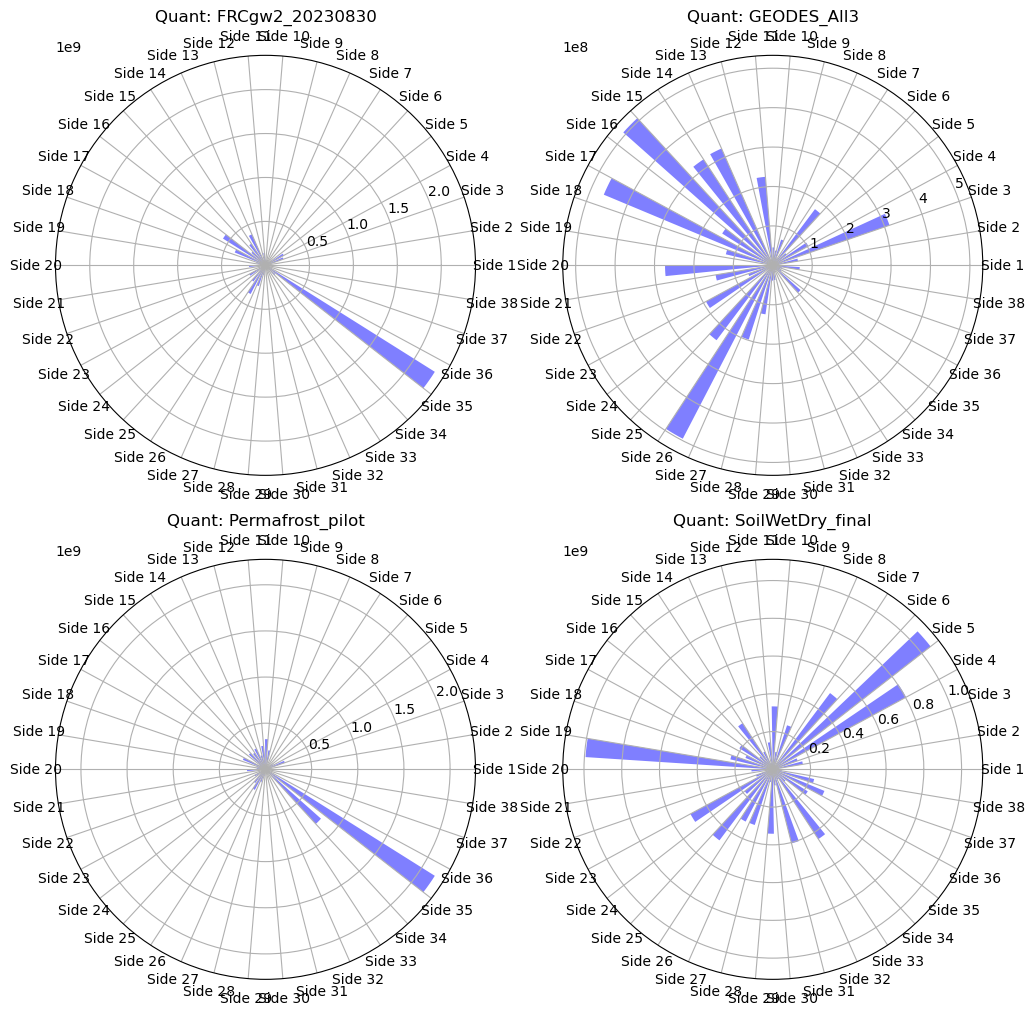

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of sides of the polygons
num_sides = bar_df.shape[0]

# Define the angles for each side of the polygons
angles = np.linspace(0, 2 * np.pi, num_sides + 1)[:-1]



# Create the polar plot
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12),subplot_kw={'projection': 'polar'})
ax = ax.flatten()

for i in range(len(ax)):
    # Define the lengths of the bars
    bar_lengths = bar_df.values[:,i]
    # Plot the bars
    ax[i].bar(angles, bar_lengths, width=0.1, align='edge', color='blue', alpha=0.5)


    # Set the labels for each side of the polygons
    ax[i].set_xticks(angles)
    ax[i].set_xticklabels(['Side {}'.format(i+1) for i in range(num_sides)])

    # Set the title of the plot
    ax[i].set_title(bar_df.columns[i])

# Show the plot
plt.show()


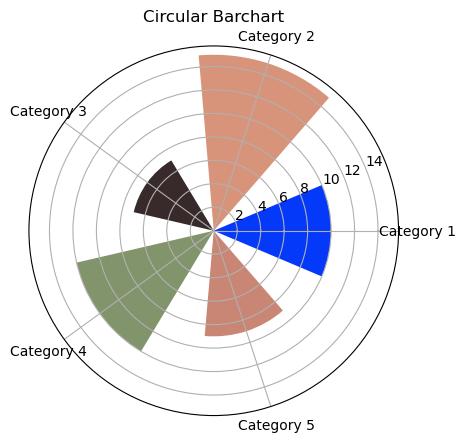

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
values = [10, 15, 7, 12, 9]

# Convert values to radians
theta = np.linspace(0.0, 2 * np.pi, len(categories), endpoint=False)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
bars = ax.bar(theta, values)

# Set the color of each bar
for bar in bars:
    bar.set_facecolor(np.random.rand(3))

# Set the labels for each category
ax.set_xticks(theta)
ax.set_xticklabels(categories)

# Set the title of the plot
ax.set_title('Circular Barchart')

# Show the plot
plt.show()
